# Work plan
1. Download data
1. Organize data into folders
1. Finetune vgg model
1. Train model
1. Run predictions
1. Evaluate predictions
1. Submit to Kaggle

## Download data
Done offline with Kaggle command line utility in Terminal ssh session. Unzip files.

Confirmed below

## Organize data into folders
only run once

In [3]:
# frequent file shortcuts
import os, sys
current_directory = os.getcwd()
UTIL_DIR = '/home/ubuntu/nbs/utils/'
LESSON_HOME_DIR = current_directory
DATA_HOME_DIR = current_directory+'/data/invasive_species'

In [4]:
# set path variables
sys.path.insert(1, LESSON_HOME_DIR)
sys.path.insert(1, UTIL_DIR)
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [5]:
sys.path

['',
 '..',
 '/home/ubuntu/nbs/utils/',
 '/home/ubuntu/nbs/lesson1',
 '/home/ubuntu/anaconda2/lib/python27.zip',
 '/home/ubuntu/anaconda2/lib/python2.7',
 '/home/ubuntu/anaconda2/lib/python2.7/plat-linux2',
 '/home/ubuntu/anaconda2/lib/python2.7/lib-tk',
 '/home/ubuntu/anaconda2/lib/python2.7/lib-old',
 '/home/ubuntu/anaconda2/lib/python2.7/lib-dynload',
 '/home/ubuntu/anaconda2/lib/python2.7/site-packages',
 '/home/ubuntu/anaconda2/lib/python2.7/site-packages/Sphinx-1.4.6-py2.7.egg',
 '/home/ubuntu/anaconda2/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg',
 '/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/extensions',
 '/home/ubuntu/.ipython']

In [8]:
#import utility modules
from utils import *

#plotting in jupyter notebook
%matplotlib inline

In [35]:
# make directories
%mkdir -p data/invasive_species/train/invasive
%mkdir -p data/invasive_species/train/harmless
%mkdir -p data/invasive_species/valid/invasive
%mkdir -p data/invasive_species/valid/harmless
%mkdir -p data/invasive_species/test/unknown
%mkdir -p data/invasive_species/sample/train/invasive
%mkdir -p data/invasive_species/sample/train/harmless
%mkdir -p data/invasive_species/sample/valid/invasive
%mkdir -p data/invasive_species/sample/valid/harmless
%mkdir -p data/invasive_species/results

In [61]:
#confirm training data & csv file with labels correctly loaded
#downloaded and unpacked in terminal. 
%cd $DATA_HOME_DIR/train
%ls *.jpg | head -5
print("\ntrain_labels.csv")
!head -5 train_labels.csv

/home/ubuntu/nbs/lesson1/data/invasive_species/train
1000.jpg
1001.jpg
1002.jpg
1003.jpg
1004.jpg
ls: write error

train_labels.csv
name,invasive
1,0
2,0
3,1
4,0


In [67]:
#need to move images with '1' label into invasive folder and those with '0' to harmless folder
import csv
import numpy as np

reader = csv.reader(open("train_labels.csv", "rb"), delimiter=",")
labels = list(reader)
del labels[0]
labels[0:5]

[['1', '0'], ['2', '0'], ['3', '1'], ['4', '0'], ['5', '1']]

In [72]:
#confirm labels for all training data. 2295 from contest page.
len(labels) == 2295

True

In [83]:
for l in labels:
    iname = l[0] + ".jpg"
    if l[1] == '0':
        !mv -t harmless/ $iname
    elif l[1]== '1':
        !mv -t invasive/ $iname

mv: cannot stat '1.jpg': No such file or directory
mv: cannot stat '2.jpg': No such file or directory
mv: cannot stat '3.jpg': No such file or directory
mv: cannot stat '4.jpg': No such file or directory
mv: cannot stat '5.jpg': No such file or directory


In [112]:
ls

harmless/  invasive/  train_labels.csv


In [13]:
%cd $DATA_HOME_DIR
!tree -d

/home/ubuntu/nbs/lesson1/data/invasive_species
.
├── results
├── sample
│   ├── train
│   │   ├── harmless
│   │   └── invasive
│   └── valid
│       ├── harmless
│       └── invasive
├── test
│   └── unknown
├── train
│   ├── harmless
│   └── invasive
└── valid
    ├── harmless
    └── invasive

16 directories


In [120]:
#make validation files
val_percentage = 0.1
num_validations = int(2295/2 * val_percentage)

%cd harmless/
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(num_validations): os.rename(shuf[i], DATA_HOME_DIR+'/valid/harmless/' + shuf[i])

%cd ../invasive/
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(num_validations): os.rename(shuf[i], DATA_HOME_DIR+'/valid/invasive/' + shuf[i])

/home/ubuntu/nbs/lesson1/data/invasive_species/train/harmless


In [24]:
#make sample files
from shutil import copy
%cd $DATA_HOME_DIR
num = 10
for img in os.listdir('train/invasive/')[:num]: copy('train/invasive/'+ img, 'sample/train/invasive/')
for img in os.listdir('train/harmless/')[:num]: copy('train/harmless/'+ img, 'sample/train/harmless/')
for img in os.listdir('valid/invasive/')[:num]: copy('valid/invasive/'+ img, 'sample/valid/invasive/')
for img in os.listdir('valid/harmless/')[:num]: copy('valid/harmless/'+ img, 'sample/valid/harmless/')

/home/ubuntu/nbs/lesson1/data/invasive_species


## Finetune vgg model
using vgg16.py file from fast.ai course. Model pre-trained on Imagenet. 

See https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16.py

In [111]:
# more file shortcuts

#Set path to /sample for development speed
# path = DATA_HOME_DIR + '/sample'
path = DATA_HOME_DIR
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

In [112]:
#instantiate pretrained model
from vgg16 import Vgg16
vgg = Vgg16()

In [113]:
#finetune model with our data
batches = vgg.get_batches(train_path)
vgg.finetune(batches)

Found 2067 images belonging to 2 classes.


## Train model

In [126]:
#set attributes
num_epochs = 4
lr = 0.001
import time

In [116]:
train_batches = vgg.get_batches(train_path)
valid_batches = vgg.get_batches(valid_path)
ts = str(int(time.time()))[-5:]
latest_weights_filename = None

for epoch in range(num_epochs):
    print("\nrunning epoch %d" % epoch)
    vgg.fit(train_batches, valid_batches)
    latest_weights_filename = ts + '_vgg_%d.h5' % epoch
    vgg.model.save_weights(results_path + latest_weights_filename)

Found 2067 images belonging to 2 classes.
Found 228 images belonging to 2 classes.

running epoch 0
Epoch 1/1
2067/2067 [==============================] - 92s - loss: 0.5215 - acc: 0.8278 - val_loss: 0.2504 - val_acc: 0.9079

running epoch 1
Epoch 1/1
2067/2067 [==============================] - 83s - loss: 0.4619 - acc: 0.8573 - val_loss: 0.2843 - val_acc: 0.9079

running epoch 2
Epoch 1/1
2067/2067 [==============================] - 82s - loss: 0.4612 - acc: 0.8665 - val_loss: 0.3063 - val_acc: 0.8947

running epoch 3
Epoch 1/1
2067/2067 [==============================] - 83s - loss: 0.3643 - acc: 0.8853 - val_loss: 0.2343 - val_acc: 0.9079

running epoch 4
Epoch 1/1
2067/2067 [==============================] - 83s - loss: 0.4234 - acc: 0.8791 - val_loss: 0.2722 - val_acc: 0.9079


## Evaluate model
Evaluate some images to check our results

In [131]:
latest_weights_filename ='77272_vgg_4.h5'

In [147]:
#load weights and generate predictions of validation set for review
vgg.model.load_weights(results_path + latest_weights_filename)
valid_batches, valid_preds = vgg.test(valid_path)
valid_filenames = valid_batches.filenames
expected_labels = valid_batches.classes

Found 228 images belonging to 2 classes.


In [252]:
valid_batches.class_indices

{'harmless': 0, 'invasive': 1}

In [145]:
#round off predictions to 0 or 1 to make labels
s = valid_preds[:5]
s

array([[  1.2075e-01,   8.7925e-01],
       [  9.9946e-01,   5.4475e-04],
       [  5.8875e-01,   4.1125e-01],
       [  9.6563e-01,   3.4372e-02],
       [  9.9599e-01,   4.0070e-03]], dtype=float32)

In [139]:
#second column is probability of invasive
s[:,1]

array([  8.7925e-01,   5.4475e-04,   4.1125e-01,   3.4372e-02,   4.0070e-03], dtype=float32)

In [247]:
our_predictions = valid_preds[:,1]
#our_string_predictions = np.asarray(["%.2f" % p for p in our_predictions], dtype='|S9') #for titles- not working
our_labels = np.round(our_predictions)

In [197]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles):
    plots([image.load_img(valid_path + valid_filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

### Correctly labeled images

found 210 correct labels


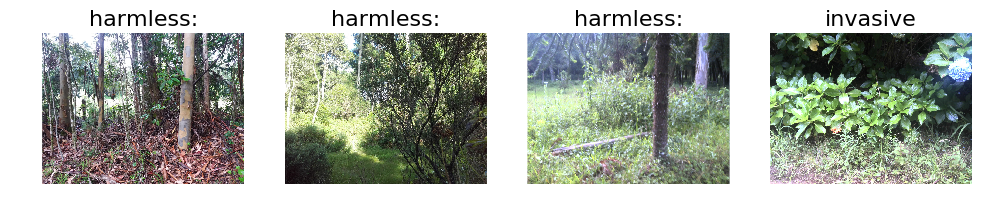

In [245]:
#selected at random
correct = np.where(our_labels == expected_labels)[0]
print("found %d correct labels" % len(correct))
idx = np.random.permutation(correct)
titles = np.where(our_labels[idx[:n_view]] == 0.0, 'harmless', 'invasive')
plots_idx(idx[:n_view], titles)

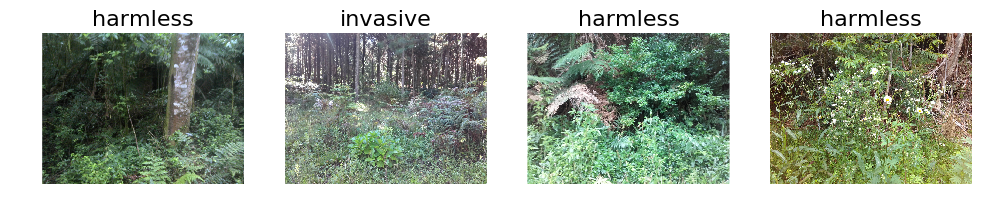

In [253]:
idx = np.random.permutation(correct)
titles = np.where(our_labels[idx[:n_view]] == 0.0, 'harmless', 'invasive')
plots_idx(idx[:n_view], titles)

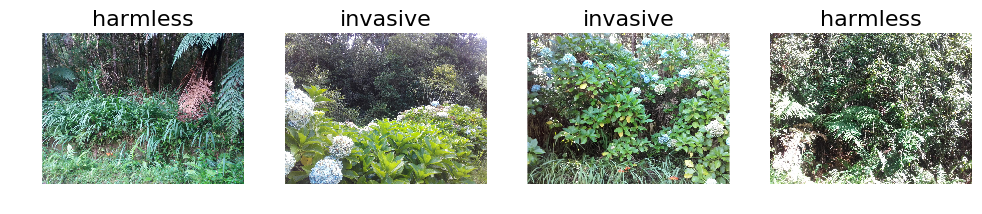

In [254]:
idx = np.random.permutation(correct)
titles = np.where(our_labels[idx[:n_view]] == 0.0, 'harmless', 'invasive')
plots_idx(idx[:n_view], titles)

### Incorrectly labeled images

found 18 incorrect labels


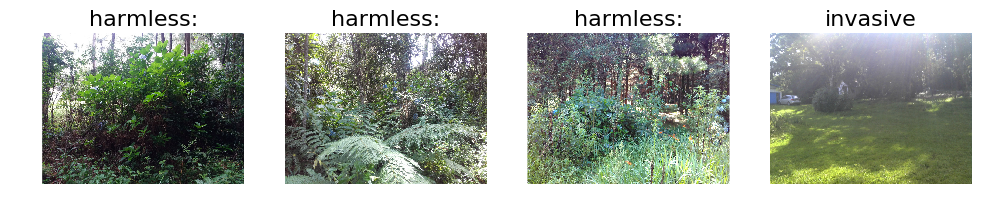

In [211]:
#selected at random
incorrect = np.where(our_labels != expected_labels)[0]
print("found %d incorrect labels" % len(incorrect))
idx = np.random.permutation(incorrect)
titles = np.where(our_labels[idx[:n_view]] == 0.0, 'harmless:', 'invasive')
plots_idx(idx[:n_view], titles)

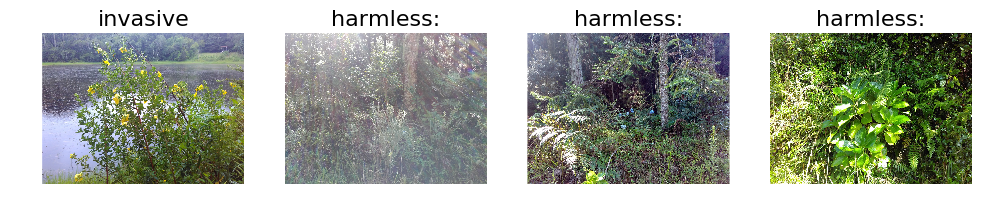

In [255]:
idx = np.random.permutation(incorrect)
titles = np.where(our_labels[idx[:n_view]] == 0.0, 'harmless:', 'invasive')
plots_idx(idx[:n_view], titles)

### Images with highest uncertainty

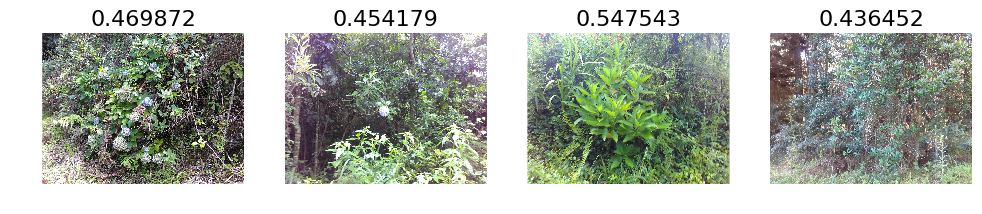

In [217]:
most_uncertain = np.argsort(abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain[:n_view]])

### Confustion matrix

[[108   6]
 [ 12 102]]


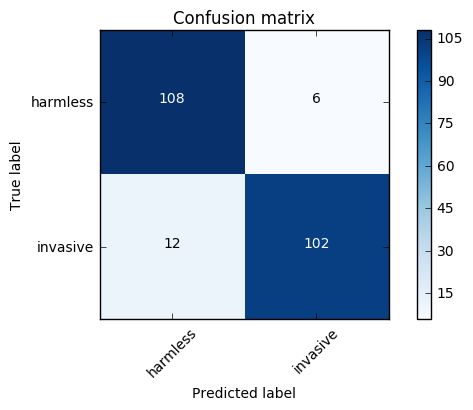

In [250]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, valid_batches.class_indices)

## Run predictions

In [256]:
#preds is a numpy array of predictions

test_batches, preds = vgg.test(test_path)

Found 1531 images belonging to 1 classes.


In [257]:
#save predictions
filenames = test_batches.filenames
ts = str(int(time.time()))[-5:]
save_array(results_path + ts + '_preds.dat', preds)
save_array(results_path + ts + '_filenames.dat', filenames)

## Evaluate predictions

In [258]:
from PIL import Image
evals = 10
image_display_size = 512, 512

In [259]:
preds[:evals]

array([[  2.1031e-03,   9.9790e-01],
       [  9.9404e-01,   5.9616e-03],
       [  9.9928e-01,   7.1731e-04],
       [  4.5786e-03,   9.9542e-01],
       [  8.5617e-01,   1.4383e-01],
       [  5.7807e-13,   1.0000e+00],
       [  5.9391e-08,   1.0000e+00],
       [  8.0980e-01,   1.9020e-01],
       [  9.3655e-01,   6.3451e-02],
       [  8.7604e-01,   1.2396e-01]], dtype=float32)

testfile 0[ 0.0021  0.9979]


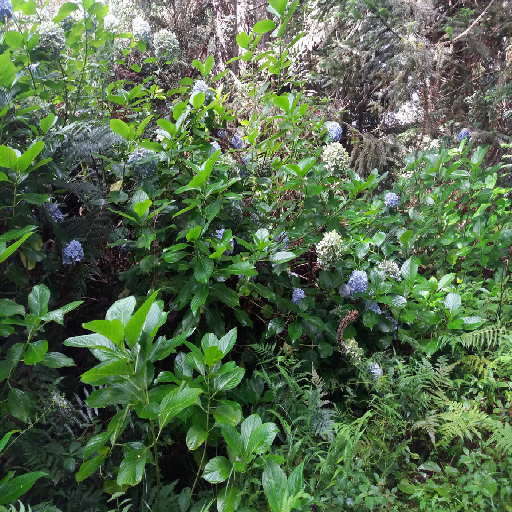

In [260]:
testfile = 0
print("testfile %d" % testfile + np.array_str(preds[testfile]))
im = Image.open(test_path + filenames[testfile])
im.resize(image_display_size)

## Submit to Kaggle
Create file then submit offline

In [274]:
%cd $results_path
ids = np.array([int(f[8:f.find('.')]) for f in filenames])
is_invasive = preds[:,1]
submission = np.stack((ids, is_invasive), axis = 1)
filename = "kevin" + ts + ".csv"
np.savetxt(filename, submission, fmt="%d,%.5f", header='name,invasive', comments='')

/home/ubuntu/nbs/lesson1/data/invasive_species/results
